# Model Training

This tutorial demonstrates the training of the ```TemporalFusionTransformer``` model.<br/>

The demonstration is using the processed version of [__*Corporación Favorita Grocery Sales Forecasting*__](https://www.kaggle.com/c/favorita-grocery-sales-forecasting/overview) dataset, as demonstrated in the __*Favorita Dataset Creation Example*__ tutorial, which is also part of this documentation.<br/>

The training routine implemented below, uses *pure* pytorch, for clarity purposes. However, it can be easily adapted to frameworks such as [__*pytorch-ignite*__](https://pytorch.org/ignite/index.html) or [__*pytorch-lightning*__](https://www.pytorchlightning.ai/) to facilitate, orchestrate, and automate some of the training procedure.

### Importing the required libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
from typing import Dict,List,Tuple
from functools import partial
import copy
import numpy as np
from omegaconf import OmegaConf,DictConfig
import pandas as pd
from tqdm import tqdm
import torch
from torch import optim
from torch import nn
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, Subset
from tft_torch.tft import TemporalFusionTransformer
import tft_torch.loss as tft_loss

### Data-related

Setting the path to the location in which we saved the processed dataset in the previous tutorial:

In [3]:
data_path = '.../data/favorita/data.pickle'

Reading the pickle we saved, and take a pick at its content:

In [ ]:
with open(data_path,'rb') as fp:
    data = pickle.load(fp)

In [5]:
list(data.keys())

['data_sets', 'feature_map', 'scalers', 'categorical_cardinalities']

Displaying the content of the ```data_sets``` key.<br/>
Note that the shapes of the array, in case you follow the previous tutorial, depends on the range of dates configured.

In [6]:
for set_name in data['data_sets']:
    print('=======')
    print(set_name)
    print('=======')
    for arr_name,arr in data['data_sets'][set_name].items():
        print(f"{arr_name} (shape,dtype)")
        print(arr.shape, arr.dtype)

train
time_index (shape,dtype)
(11532481,) object
combination_id (shape,dtype)
(11532481,) <U10
static_feats_numeric (shape,dtype)
(11532481, 0) float32
static_feats_categorical (shape,dtype)
(11532481, 9) int32
historical_ts_numeric (shape,dtype)
(11532481, 90, 4) float32
historical_ts_categorical (shape,dtype)
(11532481, 90, 7) int32
future_ts_numeric (shape,dtype)
(11532481, 30, 1) float32
future_ts_categorical (shape,dtype)
(11532481, 30, 7) int32
target (shape,dtype)
(11532481, 30) float32
validation
time_index (shape,dtype)
(120833,) object
combination_id (shape,dtype)
(120833,) <U10
static_feats_numeric (shape,dtype)
(120833, 0) float32
static_feats_categorical (shape,dtype)
(120833, 9) int32
historical_ts_numeric (shape,dtype)
(120833, 90, 4) float32
historical_ts_categorical (shape,dtype)
(120833, 90, 7) int32
future_ts_numeric (shape,dtype)
(120833, 30, 1) float32
future_ts_categorical (shape,dtype)
(120833, 30, 7) int32
target (shape,dtype)
(120833, 30) float32
test
time_ind

## Modeling configuration

We have some arguments to configure, related to the optimization methodology and to the model structure:

In [7]:
configuration = {'optimization':
                 {
                     'batch_size': {'training': 256, 'inference': 4096},
                     'learning_rate': 0.001,
                     'max_grad_norm': 1.0,
                 }
                 ,
                 'model':
                 {
                     'dropout': 0.05,
                     'state_size': 64,
                     'output_quantiles': [0.1, 0.5, 0.9],
                     'lstm_layers': 2,
                     'attention_heads': 4
                 },
                 # these arguments are related to possible extensions of the model class
                 'task_type':'regression',
                 'target_window_start': None
                }

In addition to the configuration parameters mentioned above, the model also expects the some meta data, specifying the structure of the input, including how many variables compose each input channel, and the cardinalities for the categorical variables (which are required for the embedding layers).<br/>
The meta data specified above is available as part of the pickle we created when we processed the raw data, so here it comes handy.

In [8]:
feature_map = data['feature_map']
cardinalities_map = data['categorical_cardinalities']

structure = {
    'num_historical_numeric': len(feature_map['historical_ts_numeric']),
    'num_historical_categorical': len(feature_map['historical_ts_categorical']),
    'num_static_numeric': len(feature_map['static_feats_numeric']),
    'num_static_categorical': len(feature_map['static_feats_categorical']),
    'num_future_numeric': len(feature_map['future_ts_numeric']),
    'num_future_categorical': len(feature_map['future_ts_categorical']),
    'historical_categorical_cardinalities': [cardinalities_map[feat] + 1 for feat in feature_map['historical_ts_categorical']],
    'static_categorical_cardinalities': [cardinalities_map[feat] + 1 for feat in feature_map['static_feats_categorical']],
    'future_categorical_cardinalities': [cardinalities_map[feat] + 1 for feat in feature_map['future_ts_categorical']],
}

Note that we add ``1`` to each of the categorical cardinalities. The reason for that is that the categorical cardinalities are taken from the ```LabelEncoder``` objects which were used for encoding the data in the processing phase. As these ```LabelEncoder``` objects were fit to the training subset, some categories that appeared on the later parts of the dataset (validation/test subsets) were possibly unseen by these ```LabelEncoder```s. Hence, the encodings we applied allocated/appended a new label index for each unseen category, and here we somehow *"inform"* the model the precise number of categories the model will need to embed for each attribute.

Adding the input structure we inferred to the configuration object:

In [9]:
configuration['data_props'] = structure

## Model Creation and Initiation

The model is initiated by the configuration created above:

In [10]:
model = TemporalFusionTransformer(config=OmegaConf.create(configuration))

For initialization of the weights composing the model, we use the legendary [__snippet/gist__](https://gist.github.com/jeasinema/ed9236ce743c8efaf30fa2ff732749f5) provided by [__jeasinema__](https://gist.github.com/jeasinema):

In [11]:
def weight_init(m):
    """
    Usage:
        model = Model()
        model.apply(weight_init)
    """
    if isinstance(m, nn.Conv1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm1d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm3d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.LSTM):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.LSTMCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRU):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
        for names in m._all_weights:
            for name in filter(lambda n: "bias" in n, names):
                bias = getattr(m, name)
                n = bias.size(0)
                bias.data[:n // 3].fill_(-1.)
    elif isinstance(m, nn.GRUCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)

In [ ]:
model.apply(weight_init)

Then we specify the device, according to the availability of *CUDA* device, and transfer the model to the device accordingly:

In [ ]:
is_cuda = torch.cuda.is_available()
device = torch.device("cuda" if is_cuda else "cpu")
model.to(device)

Now that the model is set, we initalize the optimizer, and point it to the model parameters:

In [14]:
opt = optim.Adam(filter(lambda p: p.requires_grad, list(model.parameters())),
                lr=configuration['optimization']['learning_rate'])

## Data Preparation

As a utility class, we will declare ``DictDataSet`` which digests a dictionary of numpy arrays, and makes sure that each record/observation that will be retrieved using this dataset, will be output as a dictionary of tensors with keys corresponding to these of the original input dictionary.
This ``DictDataSet`` be useful because when we'll wrap it with a dedicated ``DataLoader`` object, our mini-batches will be ``dict`` objects as well, which is highly convenient.<br/>
__*Note*__: The tensor data-types are set according to the data-type of the corresponding numpy arrays.

In [15]:
class DictDataSet(Dataset):
    def __init__(self, array_dict: Dict[str, np.ndarray]):
        self.keys_list = []
        for k, v in array_dict.items():
            self.keys_list.append(k)
            if np.issubdtype(v.dtype, np.dtype('bool')):
                setattr(self, k, torch.ByteTensor(v))
            elif np.issubdtype(v.dtype, np.int8):
                setattr(self, k, torch.CharTensor(v))
            elif np.issubdtype(v.dtype, np.int16):
                setattr(self, k, torch.ShortTensor(v))
            elif np.issubdtype(v.dtype, np.int32):
                setattr(self, k, torch.IntTensor(v))
            elif np.issubdtype(v.dtype, np.int64):
                setattr(self, k, torch.LongTensor(v))
            elif np.issubdtype(v.dtype, np.float32):
                setattr(self, k, torch.FloatTensor(v))
            elif np.issubdtype(v.dtype, np.float64):
                setattr(self, k, torch.DoubleTensor(v))
            else:
                setattr(self, k, torch.FloatTensor(v))

    def __getitem__(self, index):
        return {k: getattr(self, k)[index] for k in self.keys_list}

    def __len__(self):
        return getattr(self, self.keys_list[0]).shape[0]

In addition, we'll define a function named ``recycle``, which will be used for creating some kind of "*infinite*" data loader, i.e. by wrapping a dataloader with this utility function, we make sure that we'll be able to get batches (using e.g. ``next``), and the iterator won't get to its ending state.<br/>

One last utility data-related utility function is ``get_set_and_loaders()``, which expects a ``dict`` of numpy arrays, transforms it into a ``DictDataSet`` object, and creates two data loaders for each set.
One data loader will be shuffled and, what was termed as "*infinite*", and the second one will be serial, for allowing us to perform inference on all the observations in the dataset, while keeping them in the original order.<br/>
*Note*: the input argument ``ignore_keys`` allows discarding some keys in the original dictionary, ``data_dict``, and not including them in the resulting ``DictDataSet`` and in the corresponding batches it'll produce.

In [16]:
def recycle(iterable):
    while True:
        for x in iterable:
            yield x

def get_set_and_loaders(data_dict: Dict[str, np.ndarray],
                        shuffled_loader_config: Dict,
                        serial_loader_config: Dict,
                        ignore_keys: List[str] = None,
                        ) -> Tuple[torch.utils.data.Dataset, torch.utils.data.DataLoader, torch.utils.data.DataLoader]:
    dataset = DictDataSet({k:v for k,v in data_dict.items() if (ignore_keys and k not in ignore_keys)})
    loader = torch.utils.data.DataLoader(dataset,**shuffled_loader_config)
    serial_loader = torch.utils.data.DataLoader(dataset,**serial_loader_config)
    
    return dataset,iter(recycle(loader)),serial_loader

We set the configuration for the shuffled data loaders, and for the serial ones, and we also set the ``meta_keys`` which specifies which keys do not contain actual data (only meta-data to identify each record):

In [17]:
shuffled_loader_config = {'batch_size': configuration['optimization']['batch_size']['training'],
                'drop_last': True,
                'shuffle':True}

serial_loader_config = {'batch_size': configuration['optimization']['batch_size']['inference'],
                'drop_last': False,
                'shuffle':False}

# the following fields do not contain actual data, but are only identifiers of each observation
meta_keys = ['time_index','combination_id']

We use the utility functions for generating the required data loaders for each of the subsets:

In [18]:
train_set,train_loader,train_serial_loader = get_set_and_loaders(data['data_sets']['train'],
                                                                shuffled_loader_config,
                                                                serial_loader_config,
                                                                ignore_keys=meta_keys) 
validation_set,validation_loader,validation_serial_loader = get_set_and_loaders(data['data_sets']['validation'],
                                                                shuffled_loader_config,
                                                                serial_loader_config,
                                                                ignore_keys=meta_keys) 
test_set,test_loader,test_serial_loader = get_set_and_loaders(data['data_sets']['test'],
                                                                shuffled_loader_config,
                                                                serial_loader_config,
                                                                ignore_keys=meta_keys) 

## Training Procedure

Now that everything is set in terms of the model and the data, we define some helpful utilities for easier orchestration of the training procedure.<br/>

``QueueAggregator`` is, well, a queue, which will be used as a running-window aggregator of the training performance metric. We'll use it to for smoother (and less noisier) estimation of our loss during training.

In [19]:
class QueueAggregator(object):
    def __init__(self, max_size):
        self._queued_list = []
        self.max_size = max_size

    def append(self, elem):
        self._queued_list.append(elem)
        if len(self._queued_list) > self.max_size:
            self._queued_list.pop(0)

    def get(self):
        return self._queued_list

We also employ an ``EarlyStopping`` mechanism for monitoring the performance on our validation set, and indicate when can we quit training.<br/>
This extremely [useful snippet](https://gist.github.com/stefanonardo/693d96ceb2f531fa05db530f3e21517d) was originally contributed by [stefanonardo](https://gist.github.com/stefanonardo).

In [20]:
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if torch.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)

### Training Settings

Let's go over to required parameters which will control the training routine:

In [21]:
# If early stopping is not triggered, after how many epochs should we quit training
max_epochs = 10000
# how many training batches will compose a single training epoch
epoch_iters = 200
# upon completing a training epoch, we perform an evaluation of all the subsets
# eval_iters will define how many batches of each set will compose a single evaluation round
eval_iters = 500
# during training, on what frequency should we display the monitored performance
log_interval = 20
# what is the running-window used by our QueueAggregator object for monitoring the training performance
ma_queue_size = 50
# how many evaluation rounds should we allow,
# without any improvement in the performance observed on the validation set
patience = 5

In [22]:
# initialize early stopping mechanism
es = EarlyStopping(patience=patience)
# initialize the loss aggregator for running window performance estimation
loss_aggregator = QueueAggregator(max_size=ma_queue_size)

# initialize counters
batch_idx = 0
epoch_idx = 0

For computing the loss we are seeking to optimize, we need to define a tensor, corresponding to the actual quantiles we want to estimate:

In [23]:
quantiles_tensor = torch.tensor(configuration['model']['output_quantiles']).to(device)

The following cell implements the way each batch is processed by our training/evaluation procedure. We transfer each batch component to the ``device`` we're using, feed the batch to the model, and compute the loss, using the labels (which are part of our batch), the ``predicted_quantiles`` output, and the *fixed* tensor ``quantiles_tensor`` stating the quantiles we wish to estimate.

In [24]:
def process_batch(batch: Dict[str,torch.tensor],
                  model: nn.Module,
                  quantiles_tensor: torch.tensor,
                  device:torch.device):
    if is_cuda:
        for k in list(batch.keys()):
            batch[k] = batch[k].to(device)

    batch_outputs = model(batch)
    labels = batch['target']
    
    predicted_quantiles = batch_outputs['predicted_quantiles']
    q_loss, q_risk, _ = tft_loss.get_quantiles_loss_and_q_risk(outputs=predicted_quantiles,
                                                              targets=labels,
                                                              desired_quantiles=quantiles_tensor)
    return q_loss, q_risk

Now, finally, is the actual training loop. This loop will go on until completing ``max_epoch`` rounds, or until ``EarlyStopping`` is triggered.<br/>

Each epoch starts with the evaluation of each of the subsets. Each evaluation rounds includes the processing of ``eval_iters`` batches from the relevant subset, after which the losses and the metrics are concatenated and averaged. The loss computed for the validation set is fed to the early stopping mechanism for continuous tracking.<br/>

After completing the evaluation of the data subsets, a training round, including the processing of ``epoch_iters`` batches from the training subset, is initiated. For each training batch, the computed loss is used for calling the optimizer to update the model weights, and added to the loss aggregator.

In [25]:
while epoch_idx < max_epochs:
    print(f"Starting Epoch Index {epoch_idx}")
    
    # evaluation round
    model.eval() 
    with torch.no_grad():
        # for each subset
        for subset_name, subset_loader in zip(['train','validation','test'],[train_loader,validation_loader,test_loader]):
            print(f"Evaluating {subset_name} set")
            
            q_loss_vals, q_risk_vals = [],[] # used for aggregating performance along the evaluation round
            for _ in range(eval_iters):
                # get batch
                batch = next(subset_loader)
                # process batch
                batch_loss,batch_q_risk = process_batch(batch=batch,model=model,quantiles_tensor=quantiles_tensor,device=device)
                # accumulate performance
                q_loss_vals.append(batch_loss)
                q_risk_vals.append(batch_q_risk)
            
            # aggregate and average
            eval_loss = torch.stack(q_loss_vals).mean(axis=0)
            eval_q_risk = torch.stack(q_risk_vals,axis=0).mean(axis=0)
            
            # keep for feeding the early stopping mechanism
            if subset_name == 'validation':
                validation_loss = eval_loss
            
            # log performance
            print(f"Epoch: {epoch_idx}, Batch Index: {batch_idx}" + \
                  f"- Eval {subset_name} - " + \
                  f"q_loss = {eval_loss:.5f} , " + \
                  " , ".join([f"q_risk_{q:.1} = {risk:.5f}" for q,risk in zip(quantiles_tensor,eval_q_risk)]))
    
    # switch to training mode
    model.train()
    
    # update early stopping mechanism and stop if triggered
    if es.step(validation_loss):
        print('Performing early stopping...!')
        break
    
    # initiating a training round
    for _ in range(epoch_iters):
        # get training batch
        batch = next(train_loader)
        
        opt.zero_grad()
        # process batch
        loss,_ = process_batch(batch=batch,
                              model=model,
                              quantiles_tensor=quantiles_tensor,
                              device=device)
        # compute gradients
        loss.backward()
        # gradient clipping
        if configuration['optimization']['max_grad_norm'] > 0:
            nn.utils.clip_grad_norm_(model.parameters(), configuration['optimization']['max_grad_norm'])
        # update weights
        opt.step()
        
        # accumulate performance
        loss_aggregator.append(loss.item())
        
        # log performance
        if batch_idx % log_interval == 0:
            print(f"Epoch: {epoch_idx}, Batch Index: {batch_idx} - Train Loss = {np.mean(loss_aggregator.get())}")
        
        # completed batch
        batch_idx += 1
        
    # completed epoch
    epoch_idx += 1

Starting Epoch Index 0
Evaluating train set
Epoch: 0, Batch Index: 0- Eval train - q_loss = 4.75915 , q_risk_0.1 = 0.99406 , q_risk_0.5 = 5.24727 , q_risk_0.9 = 5.65399
Evaluating validation set
Epoch: 0, Batch Index: 0- Eval validation - q_loss = 4.44160 , q_risk_0.1 = 1.30954 , q_risk_0.5 = 4.96685 , q_risk_0.9 = 4.80658
Evaluating test set
Epoch: 0, Batch Index: 0- Eval test - q_loss = 4.73196 , q_risk_0.1 = 1.01745 , q_risk_0.5 = 5.26701 , q_risk_0.9 = 5.63625
Epoch: 0, Batch Index: 0 - Train Loss = 4.66927433013916
Epoch: 0, Batch Index: 20 - Train Loss = 1.0521832619394575
Epoch: 0, Batch Index: 40 - Train Loss = 0.8945479901825509
Epoch: 0, Batch Index: 60 - Train Loss = 0.6945045125484467
Epoch: 0, Batch Index: 80 - Train Loss = 0.5805041736364365
Epoch: 0, Batch Index: 100 - Train Loss = 0.47956503987312316
Epoch: 0, Batch Index: 120 - Train Loss = 0.44512289881706235
Epoch: 0, Batch Index: 140 - Train Loss = 0.43657967865467073
Epoch: 0, Batch Index: 160 - Train Loss = 0.4327

# Explore Model Outputs

After training the model, we can use it and its outputs for a better understanding of its performance, and for trying to explain its estimations. That is what will be demonstrated in this tutorial, using the module ``tft_torch.tft_vis``.<br/>
We will rely on the dataset we produced on the dataset creation tutorial and on the model we trained in the model training tutorial.

In [26]:
import tft_torch.visualize as tft_vis

### Apply the model

For collecting the outputs of the model, we'll first run inference on the validation subset.<br/>
Here we use the serial data loader assigned above:

In [27]:
model.eval() # switch to evaluation mode

output_aggregator = dict() # will be used for aggregating the outputs across batches

with torch.no_grad():
    # go over the batches of the serial data loader
    for batch in tqdm(validation_serial_loader):
        # process each batch
        if is_cuda:
            for k in list(batch.keys()):
                batch[k] = batch[k].to(device)
        batch_outputs = model(batch)
        
        # accumulate outputs, as well as labels
        for output_key,output_tensor in batch_outputs.items():
            output_aggregator.setdefault(output_key,[]).append(output_tensor.cpu().numpy())
        output_aggregator.setdefault('target',[]).append(batch['target'].cpu().numpy())

100%|██████████| 30/30 [00:10<00:00,  2.82it/s]


and then stack the outpus from all the batches:

In [28]:
validation_outputs = dict()
for k in list(output_aggregator.keys()):
    validation_outputs[k] = np.concatenate(output_aggregator[k],axis=0)

Let's say the subset we're working with includes $N$ observations, and each observation consists of:
- a historical time-series that includes $m_{historical}$ temporal variables, spanning $T_{past}$ past time-steps.
- a *futuristic* time-series including $m_{future}$ temporal variables, spanning $T_{fut}$ futuristic time-steps.
- a set of $m_{static}$ static variables.
In addition, let's assume that the model is configured to estimate $d_q$ different quantiles.

In such case the outputs of the model will be as follows:
- ``predicted_quantiles`` - the model quantile estimates for each temporal future steps, shaped as $[N \times T_{fut} \times d_q]$.
- ``static_weights`` - the selection weights associated with the static variables for each observations, shaped as $[N \times m_{static}]$. 
- ``historical_selection_weights`` - the selection weights associated with the historical temporal variables, for each observation, and past time-step, shaped as $[N \times T_{past} \times m_{historical}]$.
- ``future_selection_weights`` - the selection weights associated with the future temporal variables, for each observation, and future time-step, shaped as $[N \times T_{fut} \times m_{future}]$.
- ``attention_scores`` - the attention score each future time-step associates which each other time-step, for each observation, shaped as $[N \times T_{fut} \times (T_{past} + T_{fut})]$.

Some of the illustrations below will refer to a single observation (sample-level), and some will perform aggregation of the outputs for the entire subset data.<br/>
For that matter, we'll arbitrarily set an index indicating the sample/record that will be used for the demonstration of the sample-level illustrations:

In [29]:
chosen_idx = 42421

### Target Signal Trajectory

On this section we'll extract the historical sequence associated with the target variable, for the specific observation chosen, together with the futuristic label (the future target), and the predicted quantiles output by the model.

In [30]:
# the name of the target signal
target_signal = 'log_sales'
# its relative index among the set of historical numeric input variables
target_var_index = feature_map['historical_ts_numeric'].index(target_signal)
# the quantiles estimated by the trained model
model_quantiles = configuration['model']['output_quantiles']

The trajectory can be viewed in two different scales:<br/>
Our first view will refer to the normalized scale.<br/>
Recall that before feeding the data to the model, all of our input variables were scaled or encoded. because the target signal was scaled as well, the outputs of the model are also designated to estimate the target signal according to this "*new*" normalized scale.

In the follwing chart we can see:
- on the left: the historical values of the target variable.
- dashed line separating past and future.
- on the right: (solid) future target variable - what the model aims to predict
- on the right: (dashed) dashed lines associated with the predicted quantiles (see legend)
- on the right: a colored sleeve between and the lower and upper quantiles; can be seen as the uncertainty sleeve for each horizon.

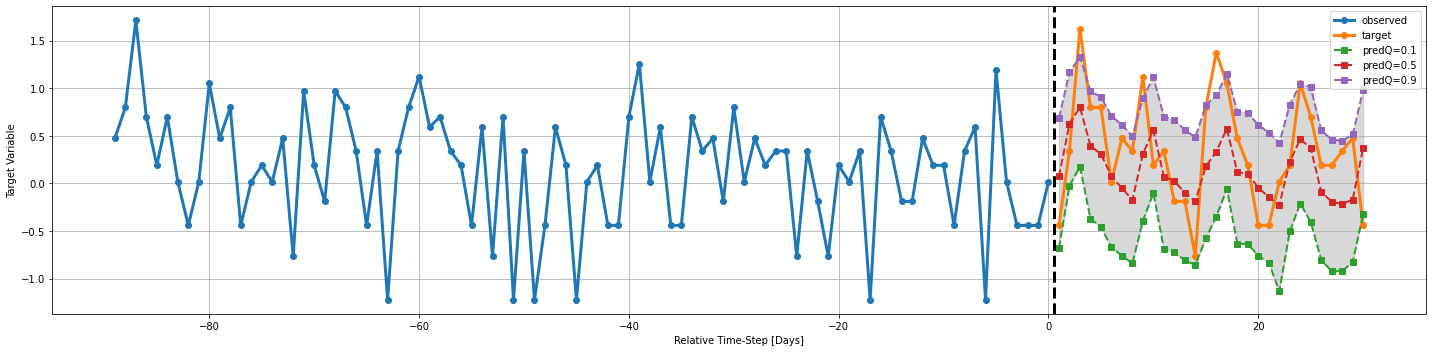

In [32]:
tft_vis.display_target_trajectory(signal_history=data['data_sets']['validation']['historical_ts_numeric'][...,target_var_index],
                                  signal_future=validation_outputs['target'],
                                  model_preds=validation_outputs['predicted_quantiles'],
                                  observation_index=chosen_idx,
                                  model_quantiles=model_quantiles,
                                  unit='Days')

However, in some cases we would like to observe the actual scale of the target variable.<br/>
For that matter, the method we're using, ``tft_vis.display_target_trajectory()`` optionally accepts also the input argument ``transformation`` , which can be used for scaling back the target variable to its original scale.<br/>

In our use case, the target variable went through a log-transform ($log_{10}(1+x)$), and then scaled using the scaler we saved along with the data. We use this to formulate the inverse scaling, and *send* this transformation to the visualization utility.

In [33]:
def scale_back(scaler_obj,signal):
    inv_trans = scaler_obj.inverse_transform(copy.deepcopy(signal))
    return np.power(10,inv_trans) - 1
transform_back = partial(scale_back,data['scalers']['numeric'][target_signal])

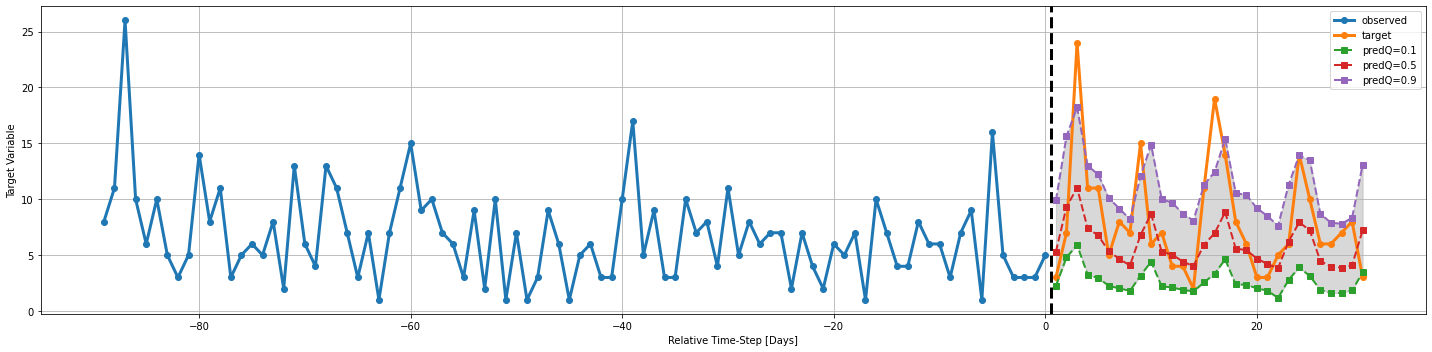

In [35]:
tft_vis.display_target_trajectory(signal_history=data['data_sets']['validation']['historical_ts_numeric'][...,target_var_index],
                                  signal_future=validation_outputs['target'],
                                  model_preds=validation_outputs['predicted_quantiles'],
                                  observation_index=chosen_idx,
                                  model_quantiles=model_quantiles,
                                  unit='Days',
                                  transformation=transform_back)

## Selection Weights
The temporal fusion transformer model has an interntal mechanism for variable selection. Each input channel has a separate dedicated mechanism - historical temporal data, static descriptors data, known future inputs data.  In the following section we'll describe them visually.

Although the input to the model required us to split between the categorical variables and the numeric variables for each input channel, after the inputs are transformed upon feeding them to the model, the entire set of variables composing a single input channel (historical_ts / future_ts / static) are treated as one block, and the variable selection mechanism acts on them without any distinction.<br/>

__*Note*__: in the suggested implementation, the numeric inputs are stacked first, before combining the categorical inputs (on each input channel separately). Hence, we conclude the complete set of input variables for each input channel as follows:

In [36]:
static_feats = feature_map['static_feats_numeric'] + feature_map['static_feats_categorical']
historical_feats = feature_map['historical_ts_numeric'] + feature_map['historical_ts_categorical']
future_feats = feature_map['future_ts_numeric'] + feature_map['future_ts_categorical']

The description of selection weights can be done either on a data subset level, or on a sample-level. For performing data-set level description, we'll have to perform some-kind of reduction/aggregation. Hence, we use a configurable list of precentiles, for describing the distribution of selection weights for each variable on each input channel:

In [37]:
# the precentiles to compute for describing the distribution of the weights
weights_prctile = [10,50,90]

On the following we use the functionality implemented under ``tft_torch.visualize``, for performing the aggregation and ordering of the attributes, for each input channel separately.<br/>
For that matter, we supply a mapping specifying the name of output key associated which each set of attributes:

In [38]:
mapping = {
    'Static Weights': {'arr_key': 'static_weights', 'feat_names':static_feats},
    'Historical Weights': {'arr_key': 'historical_selection_weights', 'feat_names':historical_feats},
    'Future Weights': {'arr_key': 'future_selection_weights', 'feat_names':future_feats},
}
tft_vis.display_selection_weights_stats(outputs_dict=validation_outputs,
                                       prctiles=weights_prctile,
                                       mapping=mapping,
                                       sort_by=50)

Static Weights


,10,50,90
item_class,0.150147,0.224345,0.303914
item_nbr,0.116679,0.175261,0.250054
store_nbr,0.077795,0.137444,0.228214
store_type,0.062463,0.096023,0.137529
city,0.058623,0.092370,0.144627
item_family,0.048706,0.086409,0.149678
store_cluster,0.040277,0.069490,0.124298
perishable,0.031059,0.053998,0.101199
state,0.008889,0.010247,0.013222


Historical Weights


,10,50,90
log_sales,0.422607,0.485794,0.534387
day_of_week,0.209394,0.270953,0.304412
onpromotion,0.034833,0.049608,0.079693
day_of_month,0.020465,0.035053,0.056229
open,0.017500,0.024302,0.041939
oil_price,0.013561,0.021311,0.034703
local_holiday,0.015344,0.020328,0.028917
transactions,0.013129,0.020139,0.027684
regional_holiday,0.010872,0.018223,0.038747
month,0.011719,0.017241,0.036102


Future Weights


,10,50,90
day_of_week,0.278989,0.354945,0.444539
day_of_month,0.111591,0.173309,0.260713
onpromotion,0.108272,0.150257,0.238843
regional_holiday,0.069319,0.097379,0.145683
national_holiday,0.043135,0.090677,0.136553
month,0.031223,0.051035,0.097063
open,0.015355,0.025633,0.043699
local_holiday,0.006801,0.009700,0.027452


The tables above display the specified percentiles of the weights distribution for each feature, on each input channel. The color of each cell is highlighted according to the corresponding value (brighter color implies higher value). In addition, every table is sorted (in descending order) according to configured percentile. Note that for the temporal inputs (historical_ts, future_ts), the time-series of weights gets "flattened", so that we can aggregate along time-steps and samples likewise. Generally, the selection weights for the temporal data, are generated for each time-step separately. Here, we look at all the time-steps altogether, but this can be another aspect to examine.

Some interesting findings that are easily seen using these tables:
- For the static weights, the attributes that seem to have the highest weights (thus considered more important), are the ones associated with the identity of the instance - *store_nbr* , *item_class* , *item_nbr* .
- The most important variable, in terms of selection weight, among the historical features, is the variable we aim at predicting into the future - *log_sales* - which makes sense, of course.
- Among the known (futuristic) inputs, we see that the knowledge about upcoming holidays is of high importance for the model.

As noted earlier, we can examine the selection weights from the point of view of an invdividual sample.
Using the functionality implemented on ``tft_torch.visualize`` we call ``display_sample_wise_selection_stats()`` function, each time for another input channel, specying the observation index for which we want to observe the selection weights distribution.


- For each of the input channel we get an ordered barplot of the selection weights. Note that for the selection weights of the temporal attributes, there's a step of flattening and averaging. For the barplot we also allow specifying the ``top_n`` argument, for keeping only the ``top_n`` ranked attributes on this plot.
Note that the selection weights on the barplot, for the static variables (which do not require flattening and aggregation) sum up to 1.0 (unless truncated using ``top_n``).
- For the selection weights of the temporal input channel, the same function will also provide some kind of "*spectrogram*" indicating the distribution of selection weights along time. This visualization can be configured to rank the attributes separately on each time-step, by setting ``rank_stepwise=True``.

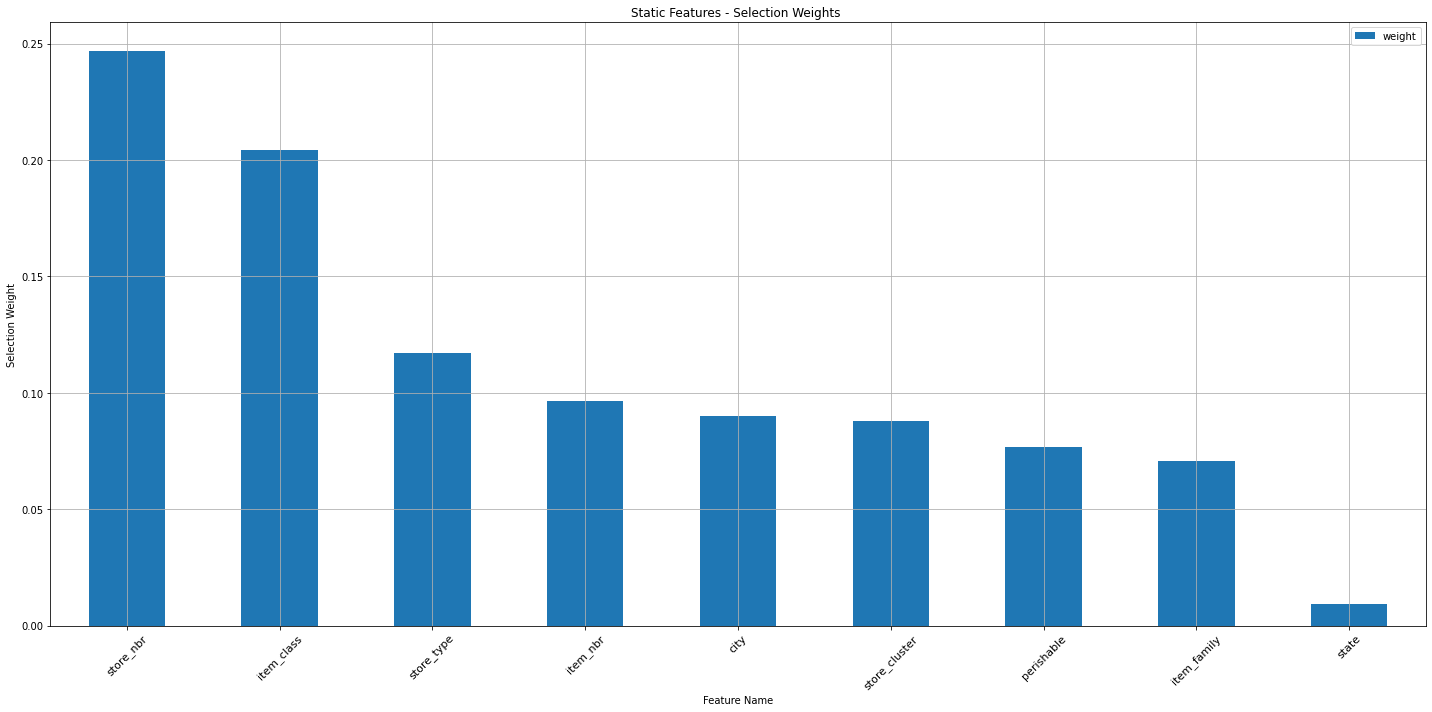

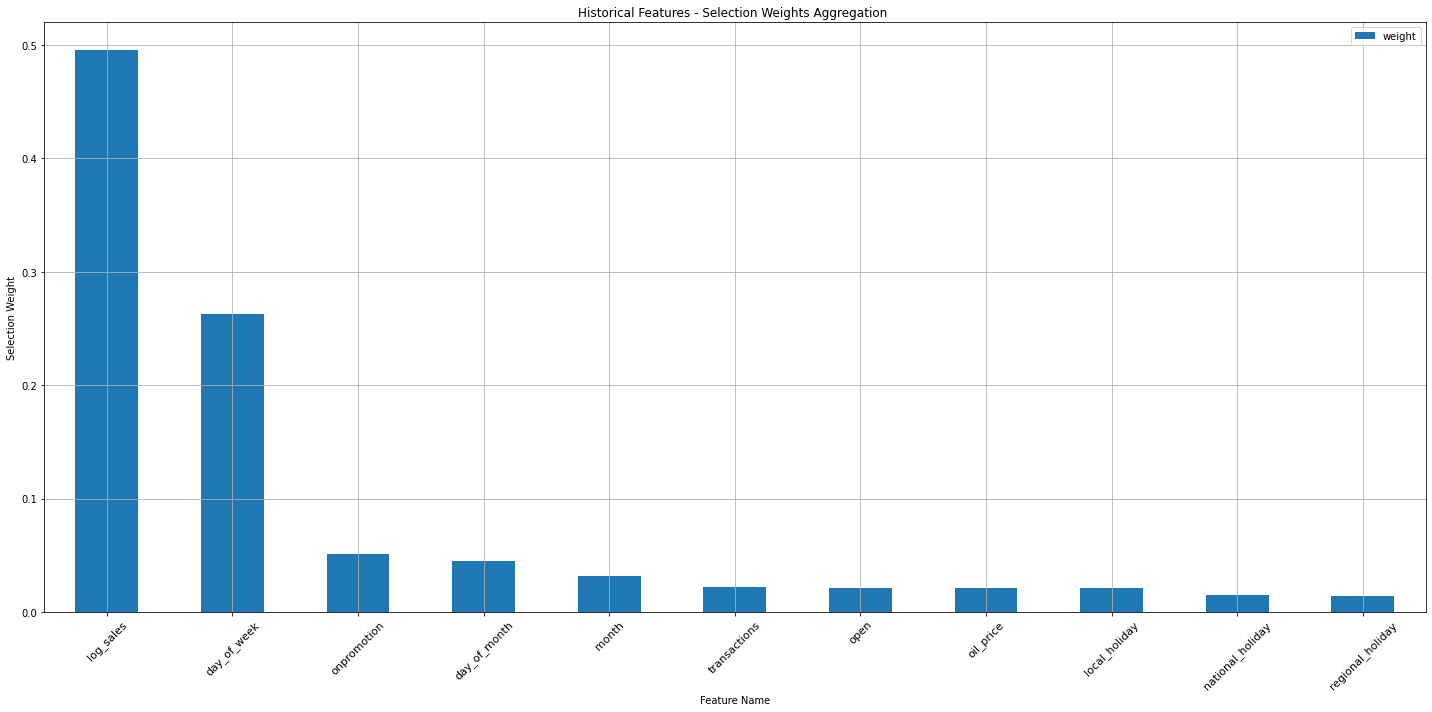

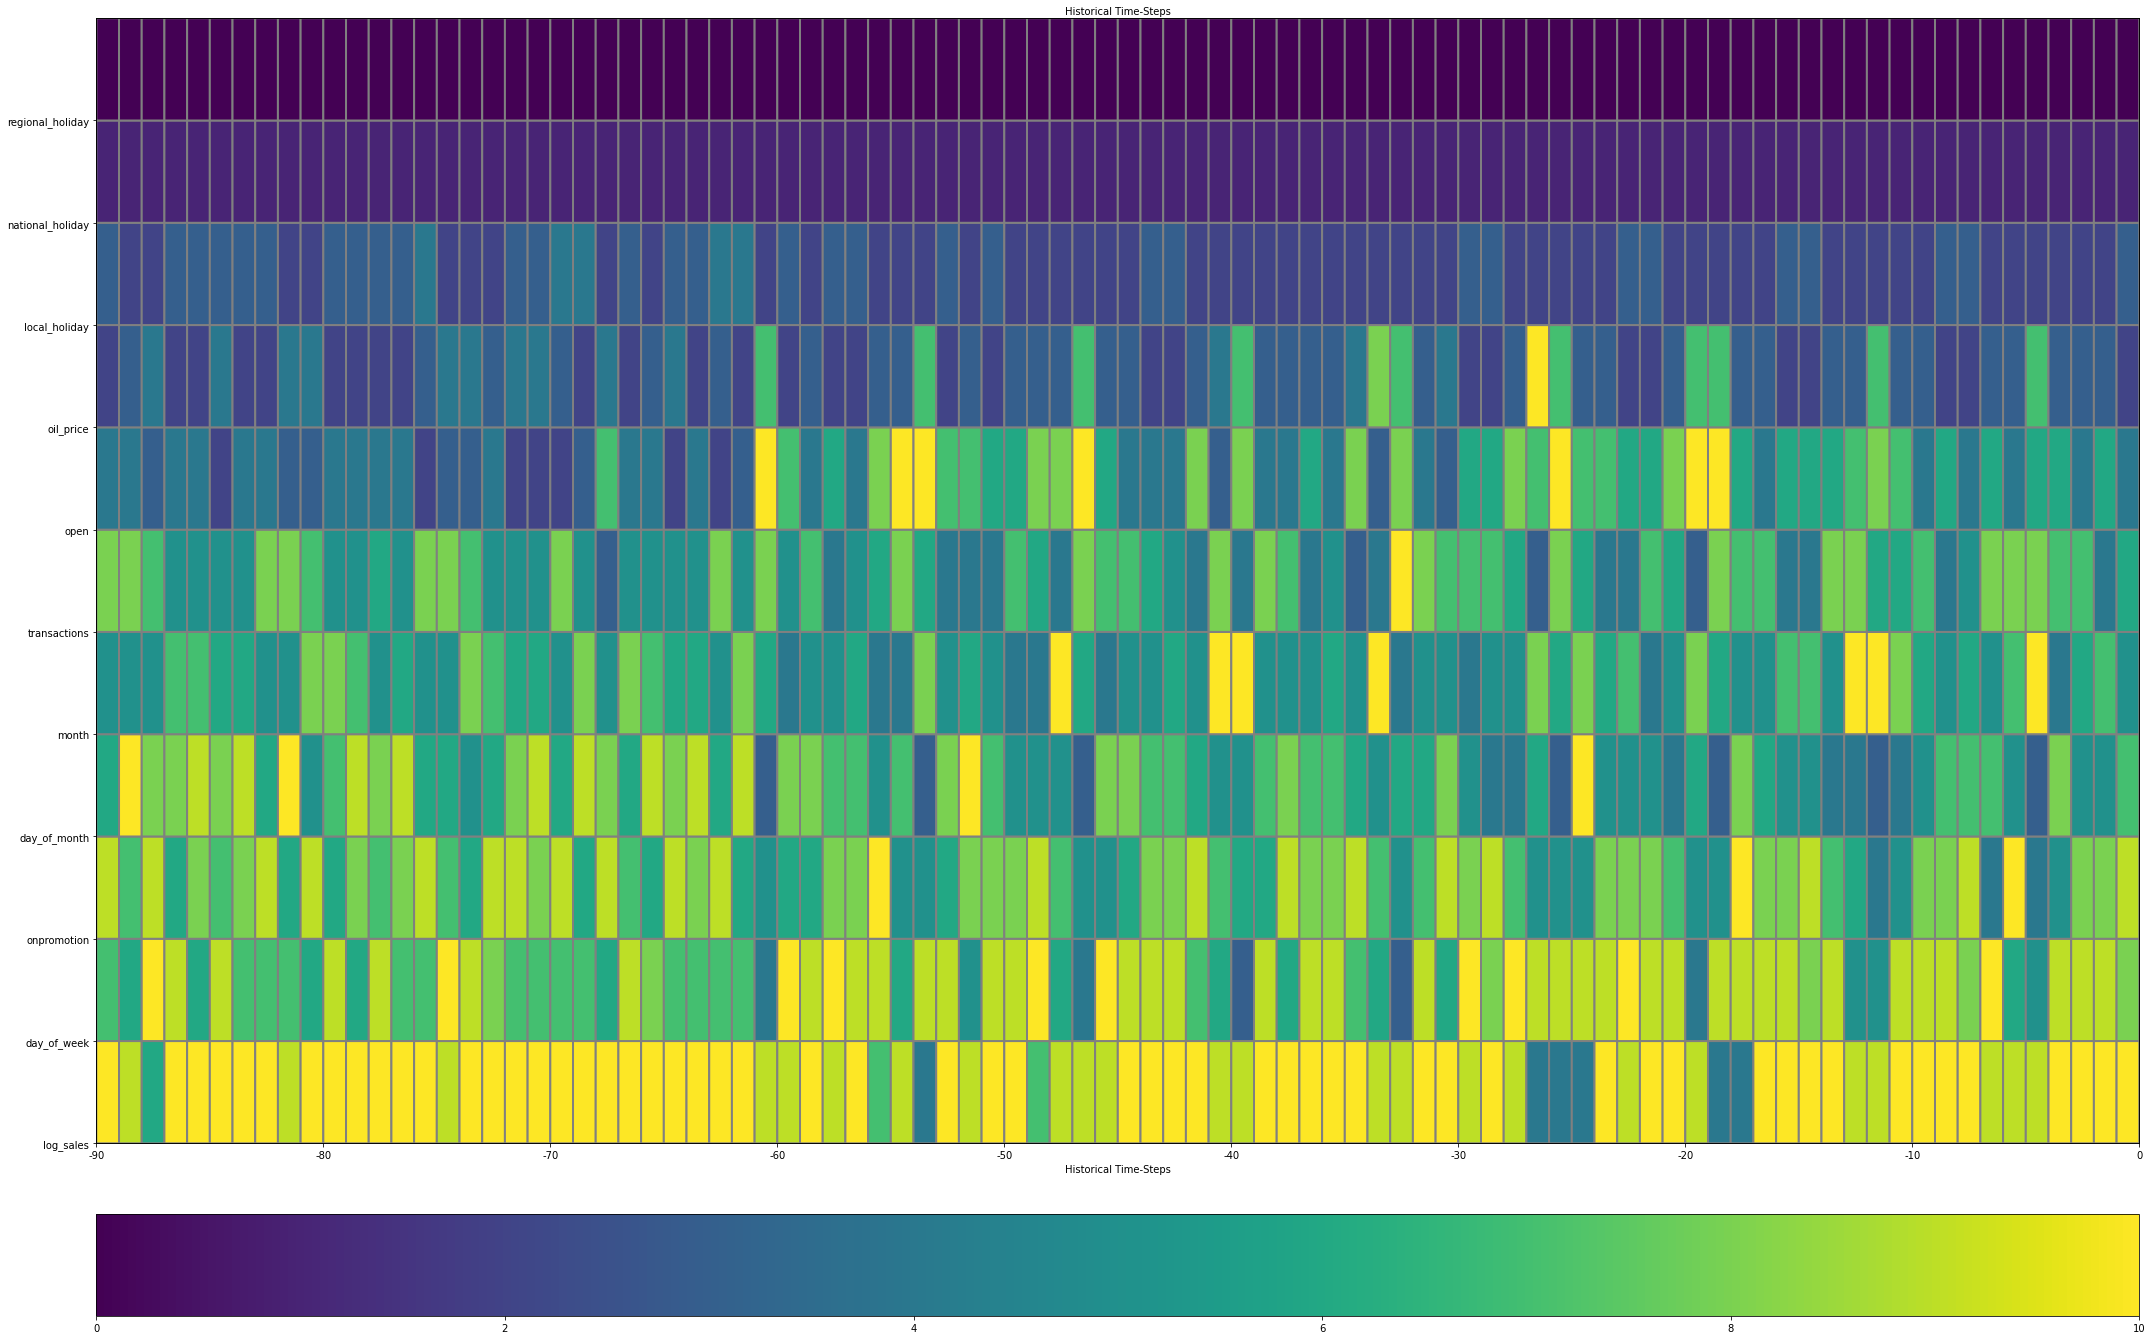

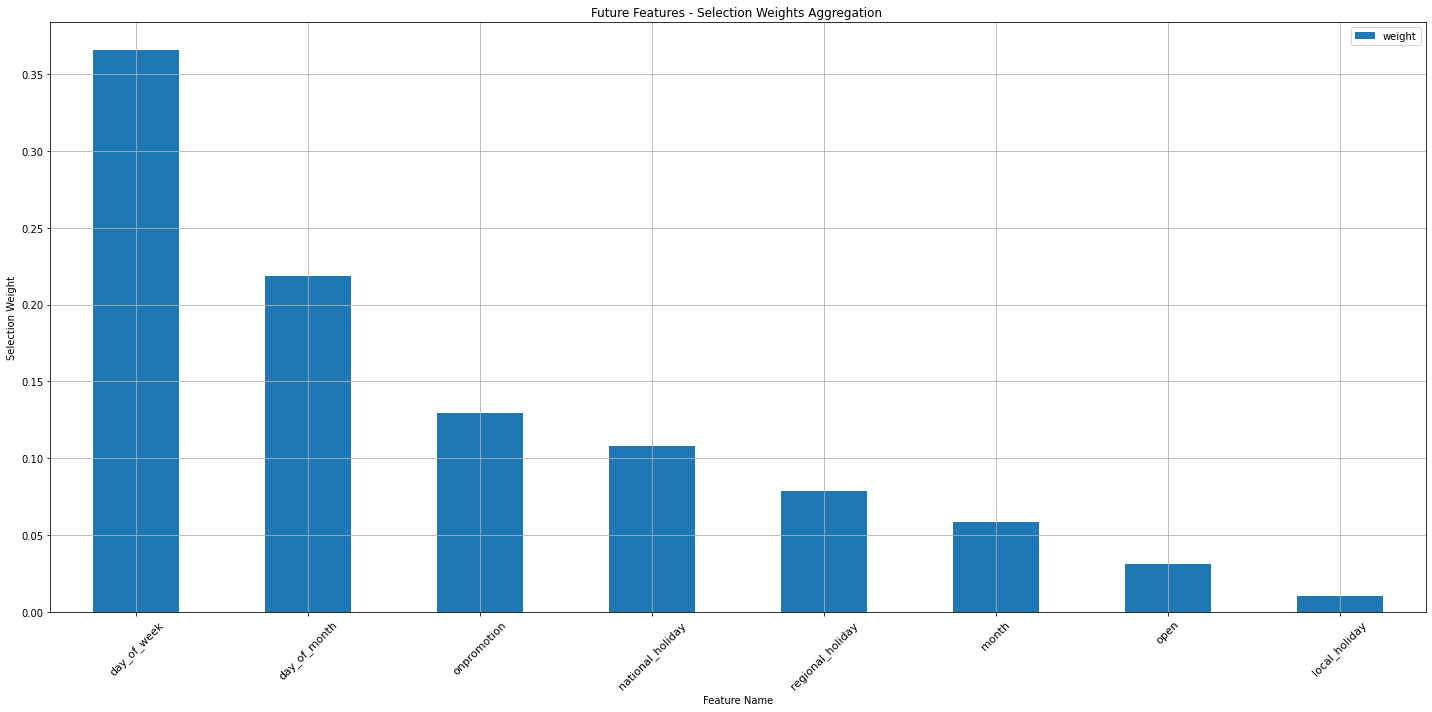

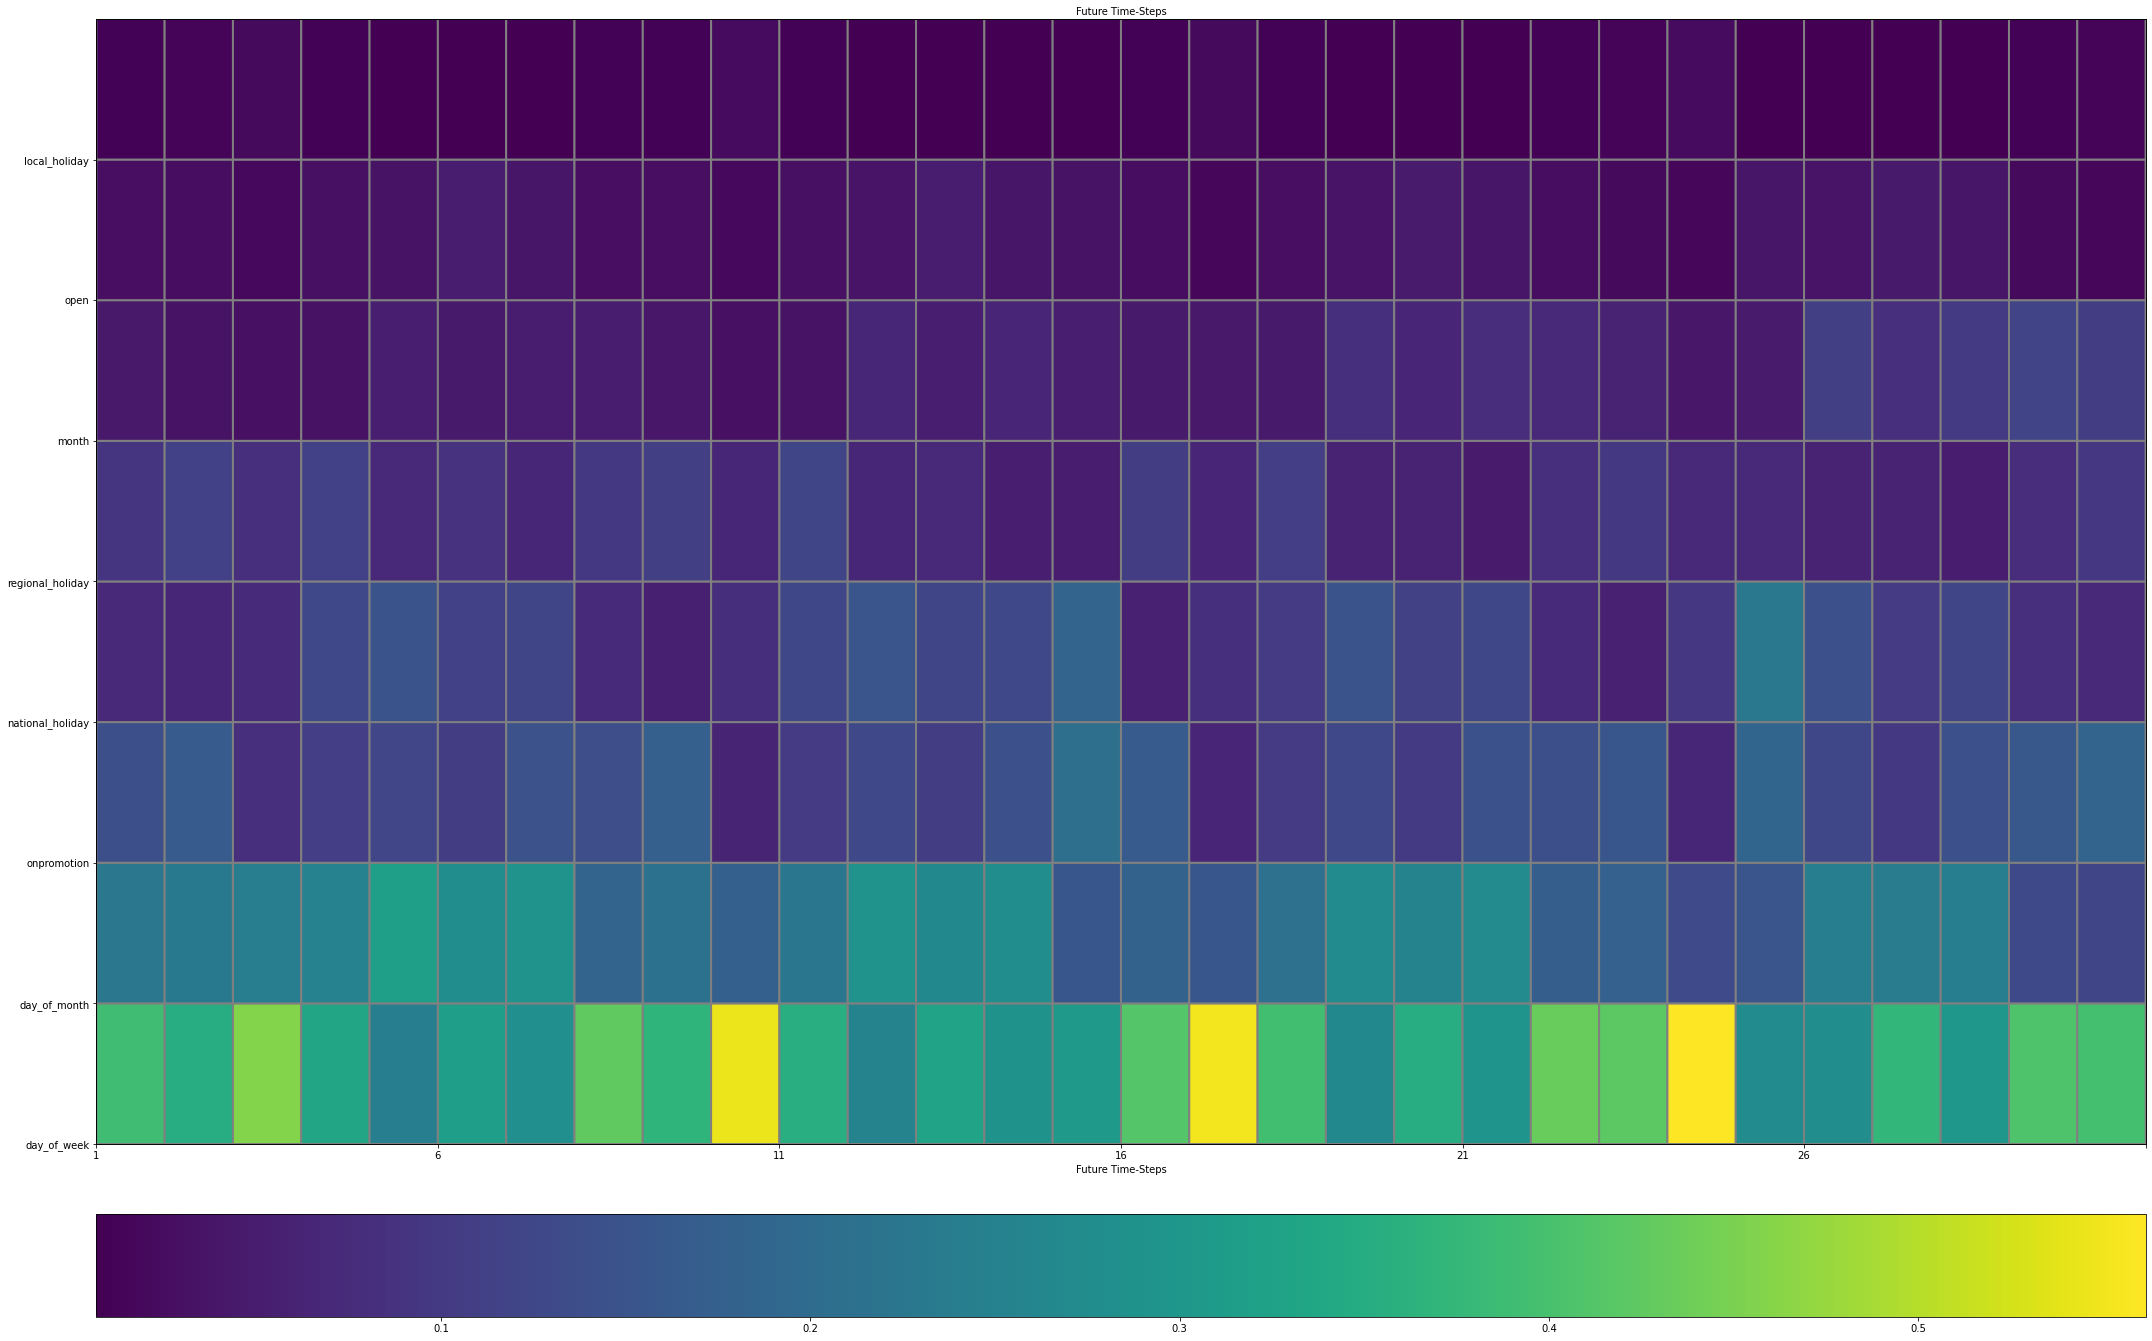

In [39]:
# static attributes
tft_vis.display_sample_wise_selection_stats(weights_arr=validation_outputs['static_weights'],
                                           observation_index=chosen_idx,
                                           feature_names=static_feats,
                                           top_n=20,
                                           title='Static Features')

# historical temporal attributes
tft_vis.display_sample_wise_selection_stats(weights_arr=validation_outputs['historical_selection_weights'],
                                           observation_index=chosen_idx,
                                           feature_names=historical_feats,
                                           top_n=20,
                                           title='Historical Features',
                                           rank_stepwise=True)

# futuristic (known) temporal attributes
tft_vis.display_sample_wise_selection_stats(weights_arr=validation_outputs['future_selection_weights'],
                                           observation_index=chosen_idx,
                                           feature_names=future_feats,
                                           top_n=20,
                                           title='Future Features',
                                           historical=False,
                                           rank_stepwise=False)

Looking at the barplots above, we can see that although in some cases the ordering of selection weights observed for the individual sample does go hand-in-hand with the ordering observed in the aggregative form (on the dataset level), this might not always be the case. Having the ability to observe selection weights on a single sample level enables us to investigate specific samples and understand which variables of this specific sample affected the model the most, and led to un/successful prediction.<br/>

Now, to the additional visualization: as explained above, the distribution of selection weights is different for each time-step. The image-like visualization is used to describe this distribution along time; higher selection weights are depicted by a brighter color.
When ``rank_stepwise`` is set to ``False``, the visualization is using a uniform scale of selection weights along the entire time axis. Therefore, on time-steps where the distribution of selection weights has higher entropy (less concentrated with a narrow set of few features), the selected input variables seem (according to chart) "less important". In order to overcome this, one can set ``rank_stepwise`` to ``True``, and the chart will display the same information, but the cells will be colored according to the order of the features (or according to their resepctive selection weight, to be precise) on each time step separately.

## Attention Scores

The temporal fusion transformer model has an internal attention mechanism for weighting the information coming from the sequential data (whether it is the historical sequence or the future sequential data). Part of the model outputs, for each observation, are the attention scores of the model. We can use these scores to try and infer which preceding time-steps affected the output of the model the most. Recall that due to masking, each Future horizon can "assign" attention only to steps that came before.<br/>
On this part, we examine the scores both globally (for the entire validation set) and individually (on a single-sample level).<br/>

As in the case of aggregating the selection weights, for supply a quantitative description of the scores distribution we use percentiles.

### One step ahead

The attention scores are horizon-specific, i.e. every future horizon maintains a different set of attention scores for the corresponding observable time-steps. First, we'll examine the attention scores for a one-day horizon (t+1) into the future.

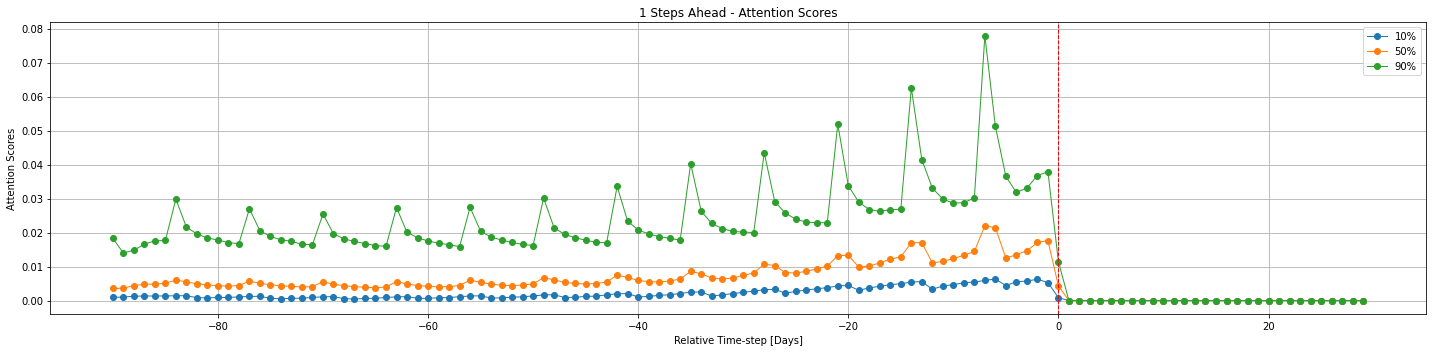

In [40]:
tft_vis.display_attention_scores(attention_scores=validation_outputs['attention_scores'],
                                horizons=1,
                                prctiles=[10,50,90],
                                unit='Days')

The dashed line stands for the separation between the historical time-steps, and the futuristic time-steps.
For each step we compute the relevant percentiles of the attention scores.
The attention scores for the further time-steps are zeroed out by design, using the internal masking mechanism within the TFT model.<br/>
We can see clearly the 7 days cycle among the attention scores, and the general trend according to which the most recent cycles (the ones that are closer to the *separation* line, are more dominant than previous, gradually forgotten, cycles.

### Multihorizon Attention
As noted above, each future horizon step has its own set of attention scores.
Using the same function we can describe the attention scores distribution for multiple horizons at once.

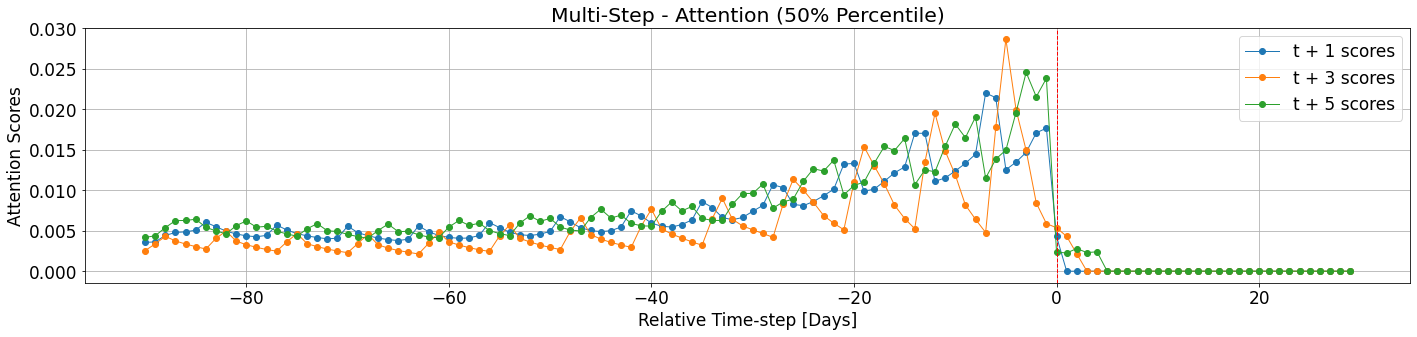

In [43]:
tft_vis.display_attention_scores(attention_scores=validation_outputs['attention_scores'],
                                horizons=[1,3,5],
                                prctiles=50,
                                unit='Days')

We can see that the attention scores for the historical time-steps have quite similiar *characteristics* among the different horizons. They all are decaying towards the past, they all have weekly cycles, but, their weekly cycles are offset due to the difference in weekdays.

The attention scores can also be explored in the single-sample level using ``display_sample_wise_attention_scores()`` function.<br/>
The following chart presents the scores associated with each output horizon (see legend). When we compare scorings of different horizons, we can see that the attention scores signal is somewhat correlated between two differnet horizon.

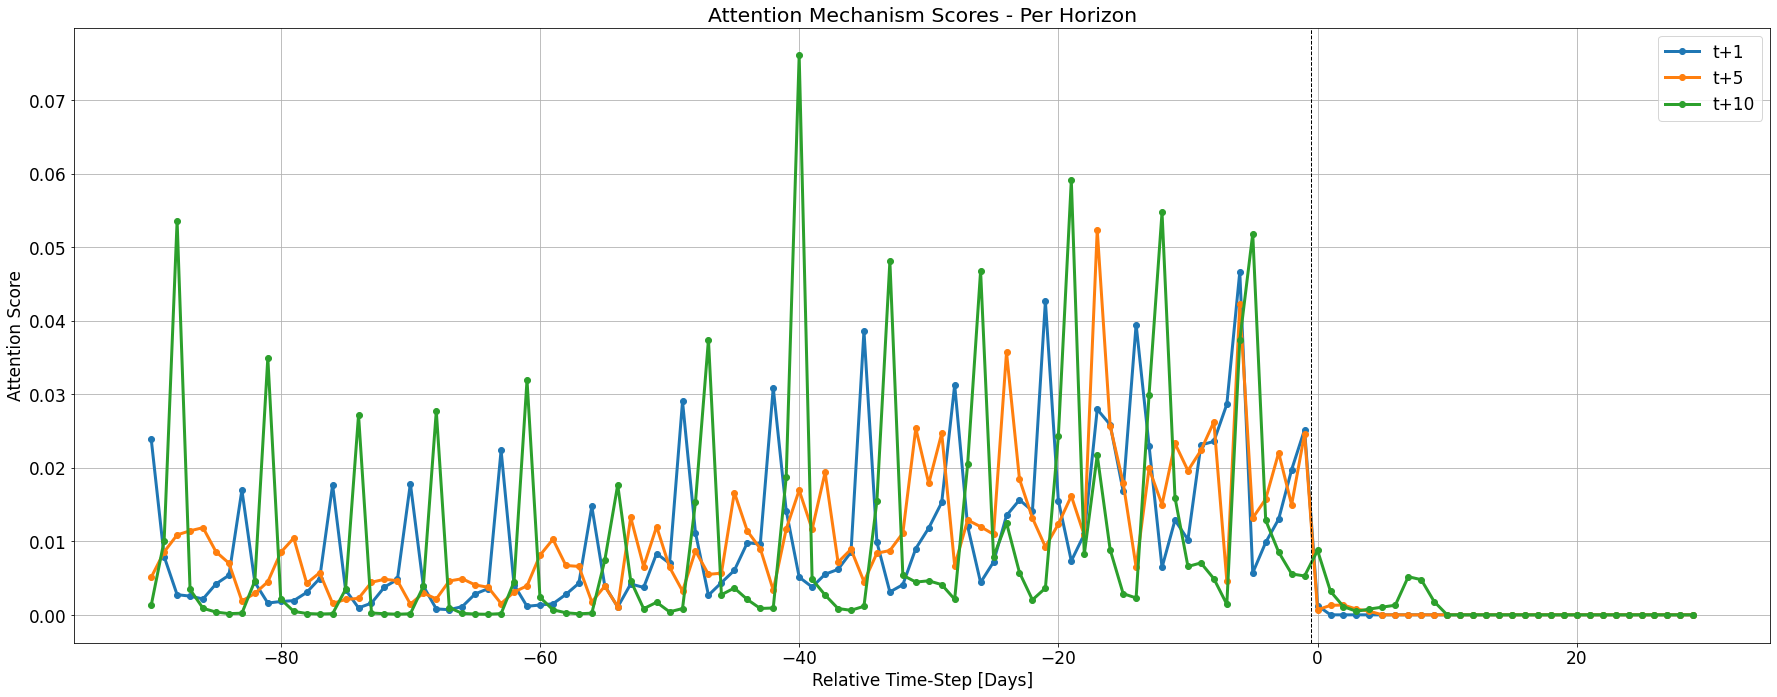

In [44]:
tft_vis.display_sample_wise_attention_scores(attention_scores=validation_outputs['attention_scores'],
                                            observation_index=chosen_idx,
                                            horizons=[1,5,10],
                                            unit='Days')

And that's it!<br/>
Enjoy using ``tft_torch``